In [18]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict, Counter
from sklearn.decomposition import TruncatedSVD
import json
import itertools
from scipy.stats import linregress
import plotly_express as px
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import math
import seaborn as sns
from scipy.signal import savgol_filter

from collections.abc import Callable
import numpy as np
import torch
from scipy.stats import entropy
from datasets import Dataset, load_dataset
from typing import Optional, Tuple
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import final, cast
import pickle
import gc
from scipy.stats import kstest

## Setup

In [19]:
def clean_cache():
    torch.cuda.empty_cache()
    gc.collect()


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


# Utils
def generate_prompt(dataset, n_ctx: int = 1, batch: int = 1) -> torch.Tensor:
    """Generate a prompt from the dataset."""
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)
    return next(iter(dataloader))["input_ids"][:, :n_ctx]


def compute_kl_div(logits_ref: torch.Tensor, logits_pert: torch.Tensor) -> torch.Tensor:
    """Compute the KL divergence between the reference and perturbed logprobs."""
    logprobs_ref = F.log_softmax(logits_ref, dim=-1)
    logprobs_pert = F.log_softmax(logits_pert, dim=-1)
    temp_output = F.kl_div(
        logprobs_ref, logprobs_pert, log_target=True, reduction="none"
    )
    return temp_output.sum(dim=-1)


def get_random_activation(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompt = generate_prompt(dataset, n_ctx=n_ctx)
    _, cache = model.run_with_cache(rand_prompt)
    return cache[layer][:, pos, :].to("cpu").detach()


def load_pretokenized_dataset(
    path: str,
    split: str,
) -> Dataset:
    dataset = load_dataset(path, split=split)
    dataset = cast(Dataset, dataset)
    return dataset.with_format("torch")


def get_random_activations(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos, n_samples
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompts = torch.cat(
        [generate_prompt(dataset, n_ctx=n_ctx) for _ in range(n_samples)]
    )
    _, cache = model.run_with_cache(rand_prompts)
    return cache[layer][:, pos, :].to("cpu").detach()


def cosine_similarity(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()


def setup_random_sampling_data_cov():
    data_mean = torch.tensor(np.load("observations_layer1/data_mean.npy"))
    data_cov = torch.tensor(np.load("observations_layer1/data_cov.npy"))
    distrib = MultivariateNormal(data_mean, data_cov)
    return distrib

In [20]:
@dataclass
class ExperimentConfig:
    n_ctx: int
    perturbation_layer: str
    read_layer: str
    perturbation_pos: slice
    n_steps: int
    perturbation_range: Tuple[float, float]
    seed: Optional[int] = None
    dataloader_batch_size: Optional[int] = None
    mean_batch_size: Optional[int] = None


class Reference:
    def __init__(
        self,
        model: HookedTransformer,
        prompt: torch.Tensor,
        perturbation_layer: str,
        read_layer: str,
        perturbation_pos: slice,
        n_ctx: int,
    ):
        self.model = model
        _, n_ctx_prompt = prompt.shape
        assert (
            n_ctx == n_ctx_prompt
        ), f"n_ctx {n_ctx} must match prompt n_ctx {n_ctx_prompt}"
        self.prompt = prompt
        logits, cache = model.run_with_cache(prompt)
        self.logits = logits.to("cpu").detach()
        self.cache = cache.to("cpu")
        self.act = self.cache[perturbation_layer][:, perturbation_pos]
        self.perturbation_layer = perturbation_layer
        self.read_layer = read_layer
        self.perturbation_pos = perturbation_pos
        self.n_ctx = n_ctx

In [21]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=1122,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0, 1),
    n_steps=100,
    mean_batch_size=512,
)

In [22]:
set_seed(cfg.seed)

In [23]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [24]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [25]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[cfg.perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

## Activation Plateaus

In [26]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_blowup_max_slope(dists, min_slope_threshold=0.02, num_steps=100):
    steps = list(range(len(dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = dists[i] - dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    if not any(np.array(slopes) > min_slope_threshold):
        return num_steps - 1

    ms_step = np.argsort(np.nan_to_num(slopes))[::-1][0]

    return ms_step


def calculate_auc(values):
    # Create x values corresponding to the indices of the values
    x = np.arange(len(values))

    # Use numpy's trapezoidal rule to calculate the area under the curve
    auc = np.trapz(values, x)

    return auc


def max_space_ratio_step(values):
    aucs = []
    for i in range(1, len(values)):
        auc = calculate_auc(values[:i])
        if auc == 0:
            aucs.append(0)
            continue
        triangle_area = (values[i - 1] * i) / 2
        aucs.append(triangle_area / auc)
    return np.argmax(aucs[5:]) + 5


def load_graph_pickle(filename):
    """Load the graph using pickle."""
    with open(filename, "rb") as f:
        return pickle.load(f)

In [27]:
distrib = setup_random_sampling_data_cov()
non_dead_feat_ids = np.where(sparsities[cfg.perturbation_layer].cpu().numpy() > -10)[0]

In [33]:
def min_max_scale(vector, feature_range=(0, 1)):
    """
    Perform min-max scaling on a vector.

    Args:
    vector (numpy.ndarray): Input vector to be scaled
    feature_range (tuple): The desired range of transformed data (default: (0, 1))

    Returns:
    numpy.ndarray: Scaled vector
    """
    min_val, max_val = feature_range

    X_std = (vector - vector.min()) / (vector.max() - vector.min())
    X_scaled = X_std * (max_val - min_val) + min_val

    return X_scaled


def custom_spread_scale(vector, target_min=0, target_max=1, center_value=0):
    """
    Scale a vector centered around a specific value to a target range.

    Args:
    vector (numpy.ndarray): Input vector to be scaled
    target_min (float): Minimum value of the target range (default: 0)
    target_max (float): Maximum value of the target range (default: 1)
    center_value (float): The value around which the original vector is centered (default: 0)

    Returns:
    numpy.ndarray: Scaled vector
    """
    # Shift the vector so that center_value becomes 0
    shifted_vector = vector - center_value

    # Find the maximum absolute value in the shifted vector
    max_abs_value = np.max(np.abs(shifted_vector))

    # Scale the shifted vector to [-1, 1] range
    normalized_vector = shifted_vector / max_abs_value

    # Scale to the target range
    scaled_vector = (normalized_vector + 1) / 2 * (target_max - target_min) + target_min

    return scaled_vector


def plot_distributions(ms_other, ms_random, ms_synth):
    plt.figure(figsize=(10, 8))

    # Histogram
    plt.subplot(2, 1, 1)

    # Determine common bins
    all_data = np.concatenate([ms_other, ms_random, ms_synth])
    bins = np.linspace(min(all_data), max(all_data), 30)

    # Plot histograms with common bins and reduced alpha
    plt.hist(
        ms_other,
        bins=bins,
        alpha=0.7,
        label="Other Activation",
        density=True,
        color="tab:orange",
    )
    plt.hist(
        ms_random, bins=bins, alpha=0.7, label="Random", density=True, color="tab:blue"
    )
    plt.hist(
        ms_synth,
        bins=bins,
        alpha=0.7,
        label="Synthetic",
        density=True,
        color="tab:green",
    )

    plt.title("Histogram Comparison")
    plt.legend()
    plt.xlabel("Value")
    plt.ylabel("Density")

    plt.xticks(np.arange(0, 101, 10))

    # CDF
    colors = ["tab:orange", "tab:blue", "tab:green"]
    plt.subplot(2, 1, 2)
    for i, (data, label) in enumerate(
        zip([ms_other, ms_random, ms_synth], ["ms_other", "ms_random", "ms_synth"])
    ):
        cdf = np.sort(data)
        plt.plot(cdf, np.linspace(0, 1, len(cdf)), label=label, color=colors[i])
    plt.title("Cumulative Distribution Function (CDF)")
    plt.legend()
    plt.xlabel("Value")
    plt.ylabel("Cumulative Probability")

    plt.tight_layout()
    plt.show()


def quantify_similarity(ms_other, ms_random, ms_synth):
    # Compute KS statistics
    ks_other_random, _ = stats.kstest(ms_other, ms_random)
    ks_other_synth, _ = stats.kstest(ms_other, ms_synth)
    ks_synth_random, _ = stats.kstest(ms_synth, ms_random)

    # Convert KS statistic to similarity (1 - KS statistic)
    # Higher values now indicate more similarity
    sim_other_random = 1 - ks_other_random
    sim_other_synth = 1 - ks_other_synth
    sim_synth_random = 1 - ks_synth_random

    print(f"Similarity score (ms_other vs ms_random): {sim_other_random:.4f}")
    print(f"Similarity score (ms_other vs ms_synth): {sim_other_synth:.4f}")
    print(f"Similarity score (ms_synth vs ms_random): {sim_synth_random:.4f}")

    # Compare relative similarities
    if sim_other_synth > sim_other_random:
        relative_similarity = sim_other_synth / sim_other_random
        print(
            f"ms_synth is {relative_similarity:.2f} times more similar to ms_other than ms_random is."
        )
    else:
        relative_similarity = sim_other_random / sim_other_synth
        print(
            f"ms_random is {relative_similarity:.2f} times more similar to ms_other than ms_synth is."
        )

    # Determine if synth is between other and random
    if (sim_other_synth > sim_other_random and sim_synth_random > sim_other_random) or (
        sim_other_synth < sim_other_random and sim_synth_random < sim_other_random
    ):
        print(
            "ms_synth appears to be between ms_other and ms_random in terms of similarity."
        )
    else:
        print(
            "ms_synth does not appear to be between ms_other and ms_random in terms of similarity."
        )


def perturb_activation(start_act, end_act, num_steps=100):
    device = start_act.device
    t = torch.linspace(0, 1, num_steps, device=device).unsqueeze(1)
    return start_act * (1 - t) + end_act * t


def perturb_activation_norm_step_size(
    start_act, end_act, step_size=0.01, num_steps=100
):
    device = start_act.device
    dir = end_act - start_act
    dir = dir / dir.norm()
    t = torch.linspace(0, num_steps, num_steps, device=device).unsqueeze(1)
    return start_act + dir * t * step_size


def run_with_perturbation(cfg, model, prompt, perturbed_acts):
    def hook(act, hook):
        act[:, -1, :] = perturbed_acts

    prompts = prompt.repeat(perturbed_acts.shape[0], 1)

    with model.hooks(fwd_hooks=[(cfg.perturbation_layer, hook)]):
        logits_pert, cache = model.run_with_cache(prompts)

    return logits_pert, cache


def get_random_acts(distrib, k=1):
    return distrib.sample([k])


def get_perturbed_acts(start_act, end_act, is_normalised, step_size):
    # swapsies for activation plateau exploration
    start_act, end_act = end_act, start_act
    if is_normalised:
        perturbed_acts = perturb_activation_norm_step_size(
            start_act, end_act, step_size=step_size
        )
        dir = end_act - start_act
        target_step = math.floor((torch.norm(dir) / step_size).item())
    else:
        perturbed_acts = perturb_activation(start_act, end_act)
        target_step = 100

    return perturbed_acts, target_step


def get_l2_norms(cache, cfg):
    read_layer_l2_norms = (
        torch.norm(
            cache[cfg.read_layer][:, -1, :] - cache[cfg.read_layer][0, -1, :],
            dim=1,
        )
        .detach()
        .cpu()
    )
    return read_layer_l2_norms


def synthetic_perturbation_random(
    start_act, is_normalised, step_size, prompt, mean_norm_sae
):
    random_feat_id = random.choice(non_dead_feat_ids)

    feat_acts = torch.zeros(sae.W_dec.shape[0])
    feat_acts[random_feat_id] = mean_norm_sae
    end_act = sae.decode(feat_acts).to(device)

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step


def other_act_perturbation(m, start_act, end_act, is_normalised, step_size, prompt):
    end_prompt = m["end_prompt"]
    with torch.no_grad():
        end_prompt_gpu = torch.tensor(end_prompt).to(device)
        _, cache = model.run_with_cache(end_prompt_gpu)
        end_act = cache[cfg.perturbation_layer][:, -1, :].squeeze(0)

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)

    pert_norm = (end_act - start_act).norm().item()

    return read_layer_l2_norms, target_step, pert_norm


def random_perturbation(start_act, is_normalised, step_size, prompt):
    end_act = get_random_acts(distrib).squeeze(0).to(device)
    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    pert_norm = (end_act - start_act).norm().item()
    return read_layer_l2_norms, target_step, pert_norm


# ---------------------- Cosine Similarity ----------------------
def synthetic_perturbation_most_similar_features(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()

    sim_scores = []

    for feat_id in active_feature_ids:
        feature_act = feature_acts[feat_id].clone().detach()
        sims = F.cosine_similarity(sae.W_dec[feat_id], sae.W_dec).detach().cpu()

        sorted_sims, sorted_indices = torch.sort(sims)
        most_similar_feature_id = sorted_indices[-2]

        feature_acts[feat_id] = 0
        feature_acts[most_similar_feature_id] = feature_act

        sim_scores.append(sorted_sims[-2])

    end_act = sae.decode(feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm


# ---------------------- Sparsity Similarity ----------------------
def synthetic_perturbation_most_similar_sparsity_features(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()

    for feat_id in active_feature_ids:
        feature_act = feature_acts[feat_id].clone().detach()
        _, sorted_indices = torch.sort(
            abs(feature_sparsities - feature_sparsities[feat_id])
        )
        most_similar_feature_id = sorted_indices[1]

        feature_acts[feat_id] = 0
        feature_acts[most_similar_feature_id] = feature_act

    end_act = sae.decode(feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm


# ---------------------- Sparsity & Cosine Similarity ----------------------
def find_best_feature(top_feature_id, spars_scores, sims, weight_sparsity=0.25):
    spars_scores = np.array(spars_scores)
    sims = np.array(sims)

    combined_scores = weight_sparsity * spars_scores + (1 - weight_sparsity) * sims
    combined_scores[top_feature_id] = float("-inf")
    best_index = np.argmax(combined_scores)

    return best_index, combined_scores[best_index]


# def synthetic_perturbation_most_similar_cos_sparsity_features(
#     sae, start_act, is_normalised, step_size, prompt
# ):
#     feature_acts = sae.encode(start_act.cpu()).detach()
#     active_feature_ids = feature_acts.nonzero().ravel()

#     for feat_id in active_feature_ids:
#         feature_act = feature_acts[feat_id].clone().detach()
#         spars_scores = 1 - abs(feature_sparsities - feature_sparsities[feat_id])
#         sims = F.cosine_similarity(sae.W_dec[feat_id], sae.W_dec).detach().cpu()
#         best_feature_id, _ = find_best_feature(feat_id, spars_scores, sims)
#         feature_acts[feat_id] = 0
#         feature_acts[best_feature_id] = feature_act

#     end_act = sae.decode(feature_acts).to(device)
#     pert_norm = (end_act - start_act).norm().item()

#     perturbed_acts, target_step = get_perturbed_acts(start_act, end_act, is_normalised, step_size)
#     _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
#     read_layer_l2_norms = get_l2_norms(cache, cfg)
#     return read_layer_l2_norms, target_step, pert_norm


def synthetic_perturbation_homeschooled_v2(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()
    top_active_feature_id = feature_acts.argsort()[-1]
    mean_sim_base_target = 0.42

    spars_scores = abs(feature_sparsities - feature_sparsities[top_active_feature_id])
    spars_scores[top_active_feature_id] = torch.inf

    candidate_feat_ids = spars_scores.argsort()[:50]

    sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[candidate_feat_ids]
        )
        .detach()
        .cpu()
    )
    candidate_feat_id = candidate_feat_ids[
        abs(sims - mean_sim_base_target).argsort()[0]
    ]

    candidate_sims = (
        F.cosine_similarity(sae.W_dec[candidate_feat_id], sae.W_dec).detach().cpu()
    )
    top_feat_sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[active_feature_ids]
        )
        .detach()
        .cpu()
    )

    candidate_feature_ids = []
    candidate_feature_acts = []

    for i, f_id in enumerate(active_feature_ids):
        feat_cos_sim = top_feat_sims[i]
        feat_act = feature_acts[f_id]
        _, candidate_feat_ids = abs(candidate_sims - feat_cos_sim).sort()

        for cf_id in candidate_feat_ids:
            if cf_id in candidate_feature_ids:
                continue

            candidate_feature_ids.append(cf_id.item())
            candidate_feature_acts.append(feat_act.item())
            break

    target_feature_acts = torch.zeros(sae.W_dec.shape[0])
    target_feature_acts[candidate_feature_ids] = torch.tensor(candidate_feature_acts)

    end_act = sae.decode(target_feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    logits_pert, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm, logits_pert


def synthetic_perturbation_most_similar_cos_sparsity_features(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()

    new_feature_acts = torch.zeros(sae.W_dec.shape[0])
    added_features = set()

    for feat_id in active_feature_ids:
        feature_act = feature_acts[feat_id].clone().detach()
        sims = F.cosine_similarity(sae.W_dec[feat_id], sae.W_dec).detach().cpu()
        candidate_feature_ids = [
            f_id.item() for f_id in sims.argsort()[-100:] if f_id != feat_id
        ]
        spars_scores = abs(
            feature_sparsities[candidate_feature_ids] - feature_sparsities[feat_id]
        )

        _, spars_indices = spars_scores.sort()

        for s_idx in spars_indices:
            substitute_feature_id = candidate_feature_ids[s_idx]
            if substitute_feature_id not in added_features:
                added_features.add(substitute_feature_id)
                break

        new_feature_acts[substitute_feature_id] = feature_act

    end_act = sae.decode(new_feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm


def synthetic_perturbation_most_similar_cheating_features(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()
    mean_sim_base_target = 0.42

    for feat_id in active_feature_ids:
        feature_act = feature_acts[feat_id].clone().detach()
        sims = F.cosine_similarity(sae.W_dec[feat_id], sae.W_dec).detach().cpu()

        # sorted_sims, sorted_indices = torch.sort(sims)
        most_similar_feature_id = abs(sims - mean_sim_base_target).argsort()[1]

        feature_acts[feat_id] = 0
        feature_acts[most_similar_feature_id] = feature_act

    end_act = sae.decode(feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm


def synthetic_perturbation_homeschooled_v2(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()
    top_active_feature_id = feature_acts.argsort()[-1]
    mean_sim_base_target = 0.42

    spars_scores = abs(feature_sparsities - feature_sparsities[top_active_feature_id])
    spars_scores[top_active_feature_id] = torch.inf

    candidate_feat_ids = spars_scores.argsort()[:100]

    sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[candidate_feat_ids]
        )
        .detach()
        .cpu()
    )
    candidate_feat_id = candidate_feat_ids[
        abs(sims - mean_sim_base_target).argsort()[0]
    ]

    candidate_sims = (
        F.cosine_similarity(sae.W_dec[candidate_feat_id], sae.W_dec).detach().cpu()
    )
    top_feat_sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[active_feature_ids]
        )
        .detach()
        .cpu()
    )

    candidate_feature_ids = []
    candidate_feature_acts = []

    for i, f_id in enumerate(active_feature_ids):
        feat_cos_sim = top_feat_sims[i]
        feat_act = feature_acts[f_id]
        _, candidate_feat_ids = abs(candidate_sims - feat_cos_sim).sort()

        for cf_id in candidate_feat_ids:
            if cf_id in candidate_feature_ids:
                continue

            candidate_feature_ids.append(cf_id.item())
            candidate_feature_acts.append(feat_act.item())
            break

    target_feature_acts = torch.zeros(sae.W_dec.shape[0])
    target_feature_acts[candidate_feature_ids] = torch.tensor(candidate_feature_acts)

    end_act = sae.decode(target_feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm


def synthetic_perturbation_graph_based(
    sae, start_act, is_normalised, step_size, prompt, G, edge_weights
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel().tolist()
    top_active_feature_id = feature_acts.argsort()[-1]
    mean_sim_base_target = 0.42

    filtered_ids = [
        f_id for f_id in non_dead_feat_ids if f_id != top_active_feature_id.item()
    ]
    spars_scores = abs(
        feature_sparsities[filtered_ids] - feature_sparsities[top_active_feature_id]
    )

    candidate_feat_ids = torch.tensor(filtered_ids)[spars_scores.argsort()][:10]

    sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[candidate_feat_ids]
        )
        .detach()
        .cpu()
    )
    candidate_feat_id = candidate_feat_ids[
        abs(sims - mean_sim_base_target).argsort()[0]
    ].item()

    candidate_feature_ids = []
    candidate_feature_acts = []
    seen_neighbors = set()

    for i, f_id in enumerate(active_feature_ids):
        feat_act = feature_acts[f_id]

        neighbors = [
            (n, edge_weights[(min(n, candidate_feat_id), max(n, candidate_feat_id))])
            for n in G.neighbors(candidate_feat_id)
            if f_id != n
        ]

        if len(neighbors) == 0:
            print(candidate_feat_id, list(iter(G.neighbors(candidate_feat_id))))

        for cf_id, s in sorted(neighbors, key=lambda t: t[1], reverse=True):
            if cf_id not in seen_neighbors:
                seen_neighbors.add(cf_id)
                break

        candidate_feature_ids.append(cf_id)
        candidate_feature_acts.append(feat_act.item())

    target_feature_acts = torch.zeros(sae.W_dec.shape[0])
    target_feature_acts[candidate_feature_ids] = torch.tensor(candidate_feature_acts)

    end_act = sae.decode(target_feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm

In [29]:
metadata, activations = [], []

pert_type = "other_act"
n_files = 10

for path in sorted(glob(f"replications/{pert_type}_metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"replications/{pert_type}_acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [30]:
def find_activation_plateau_length(dists, threshold=20):
    for i, d in enumerate(dists):
        if d >= threshold:
            return i
    return 100

In [59]:
l2_synth, l2_other, l2_random = [], [], []
ms_synth, ms_other, ms_random = [], [], []
auc_synth, auc_other, auc_random = [], [], []

idxs = random.sample(range(len(metadata)), 1000)

is_norm = True
step_size = 0.5

pert_norm_synthetic = []
pert_norm_other = []
pert_norm_random = []

# entropies_synthetic = []
# entropies_other = []
# entropies_random = []

plateau_length_synthetic = []
plateau_length_other = []
plateau_length_random = []

for idx in idxs:
    m = metadata[idx]
    acts = activations[idx]
    steps = m["steps_metadata"]
    prompt = torch.tensor(m["start_prompt"])
    start_act = torch.tensor(acts[0]).to(device)

    # Synthetic as T
    l2s, target_step, pert_norm = synthetic_perturbation_homeschooled_v2(
        sae, start_act, is_norm, step_size, prompt
    )
    plateau_length = find_activation_plateau_length(l2s)
    plateau_length_synthetic.append(plateau_length)

    blowup_step = max_space_ratio_step(l2s[:target_step])
    auc_synth.append(blowup_step)

    blowup_step = find_blowup_max_slope(l2s[:target_step])
    ms_synth.append(blowup_step)

    l2_synth.append(l2s)
    pert_norm_synthetic.append(pert_norm)

    # logits_prob = F.softmax(logits_pert[:, -1, :], dim=-1).detach().cpu()
    # entropies = [entropy(lp, base=2) for lp in logits_prob]
    # entropies_synthetic.append(entropies)

    # --------------------------------------------------------------------------
    # Other Act as T
    end_act = torch.tensor(acts[-1]).to(device)
    l2s, target_step, pert_norm = other_act_perturbation(
        m, start_act, end_act, is_norm, step_size, prompt
    )

    plateau_length = find_activation_plateau_length(l2s)
    plateau_length_other.append(plateau_length)

    blowup_step = max_space_ratio_step(l2s[:target_step])
    auc_other.append(blowup_step)

    blowup_step = find_blowup_max_slope(l2s[:target_step])
    ms_other.append(blowup_step)

    l2_other.append(l2s)
    pert_norm_other.append(pert_norm)

    # logits_prob = F.softmax(logits_pert[:, -1, :], dim=-1).detach().cpu()
    # entropies = [entropy(lp, base=2) for lp in logits_prob]
    # entropies_other.append(entropies)

    # --------------------------------------------------------------------------

    # Random as T
    l2s, target_step, pert_norm = random_perturbation(
        start_act, is_norm, step_size, prompt
    )

    plateau_length = find_activation_plateau_length(l2s)
    plateau_length_random.append(plateau_length)

    # blowup_step = find_blowup_max_slope(l2s[:target_step])
    blowup_step = max_space_ratio_step(l2s[:target_step])
    auc_random.append(blowup_step)

    blowup_step = find_blowup_max_slope(l2s[:target_step])
    ms_random.append(blowup_step)

    l2_random.append(l2s)
    pert_norm_random.append(pert_norm)

    # logits_prob = F.softmax(logits_pert[:, -1, :], dim=-1).detach().cpu()
    # entropies = [entropy(lp, base=2) for lp in logits_prob]
    # entropies_random.append(entropies)

    # --------------------------------------------------------------------------

### Activation Plateaus Plot

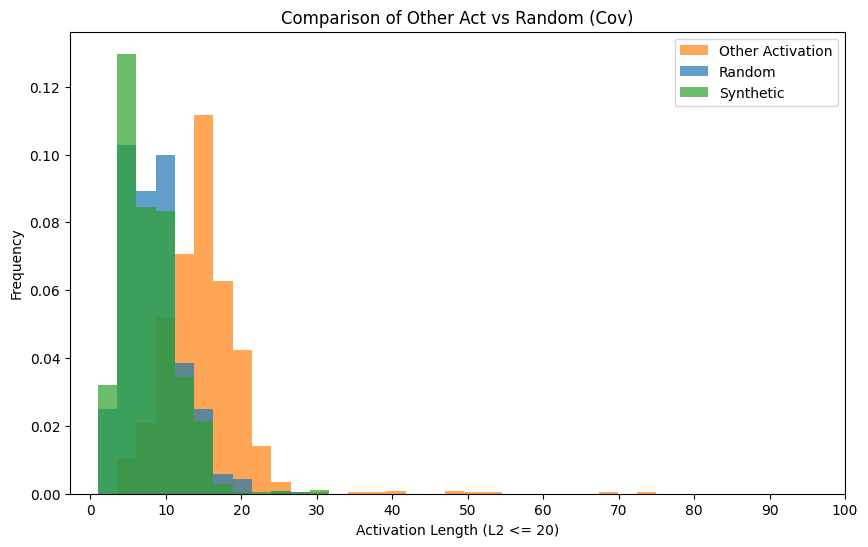

In [60]:
# Create the plot
plt.figure(figsize=(10, 6))

all_data = np.concatenate(
    [plateau_length_synthetic, plateau_length_other, plateau_length_random]
)
bins = np.linspace(min(all_data), max(all_data), 30)

# Plot both histograms
plt.hist(
    plateau_length_other,
    bins=bins,
    alpha=0.7,
    label="Other Activation",
    density=True,
    color="tab:orange",
)
plt.hist(
    plateau_length_random,
    bins=bins,
    alpha=0.7,
    label="Random",
    density=True,
    color="tab:blue",
)
plt.hist(
    plateau_length_synthetic,
    bins=bins,
    alpha=0.7,
    label="Synthetic",
    density=True,
    color="tab:green",
)

plt.xticks(np.arange(0, 101, 10))

# Customize the plot
plt.xlabel("Activation Length (L2 <= 20)")
plt.ylabel("Frequency")
plt.title("Comparison of Other Act vs Random (Cov)")
plt.legend()

# Show the plot
plt.show()

In [91]:
# top_k = 30

# for i, ent in enumerate(entropies_synthetic[:top_k]):
#     label = None if i > 0 else "synth"
#     ent_min, ent_max = min(ent), max(ent)
#     plt.plot((ent - ent_min) / (ent_max - ent_min), color="tab:green", label=label, linewidth=0.5)

# for i, ent in enumerate(entropies_other[:top_k]):
#     label = None if i > 0 else "other-act"
#     ent_min, ent_max = min(ent), max(ent)
#     plt.plot((ent - ent_min) / (ent_max - ent_min), color="tab:orange", label=label, linewidth=0.5)

# for i, ent in enumerate(entropies_random[:top_k]):
#     label = None if i > 0 else "random"
#     ent_min, ent_max = min(ent), max(ent)
#     plt.plot((ent - ent_min) / (ent_max - ent_min), color="tab:blue", label=label, linewidth=0.5)

# plt.xlabel("Perturbation Steps")
# plt.ylabel("Entropy")
# plt.legend()
# plt.show()

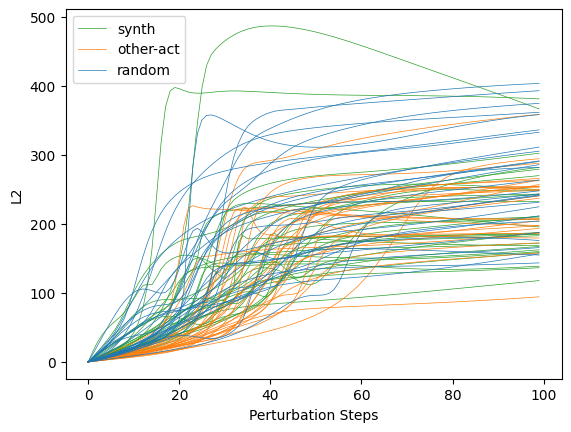

In [61]:
top_k = 30

for i, l2 in enumerate(l2_synth[:top_k]):
    if max(l2) > 500:
        continue
    label = None if i > 0 else "synth"
    plt.plot(l2, color="tab:green", label=label, linewidth=0.5)

for i, l2 in enumerate(l2_other[:top_k]):
    if max(l2) > 500:
        continue
    label = None if i > 0 else "other-act"
    plt.plot(l2, color="tab:orange", label=label, linewidth=0.5)

for i, l2 in enumerate(l2_random[:top_k]):
    if max(l2) > 500:
        continue
    label = None if i > 0 else "random"
    plt.plot(l2, color="tab:blue", label=label, linewidth=0.5)

plt.xlabel("Perturbation Steps")
plt.ylabel("L2")
plt.legend()
plt.show()

In [57]:
# idx = 8
# plt.plot(l2_other[idx])
# print(max_space_ratio_step(l2_other[idx]))

### Max Slope Plots

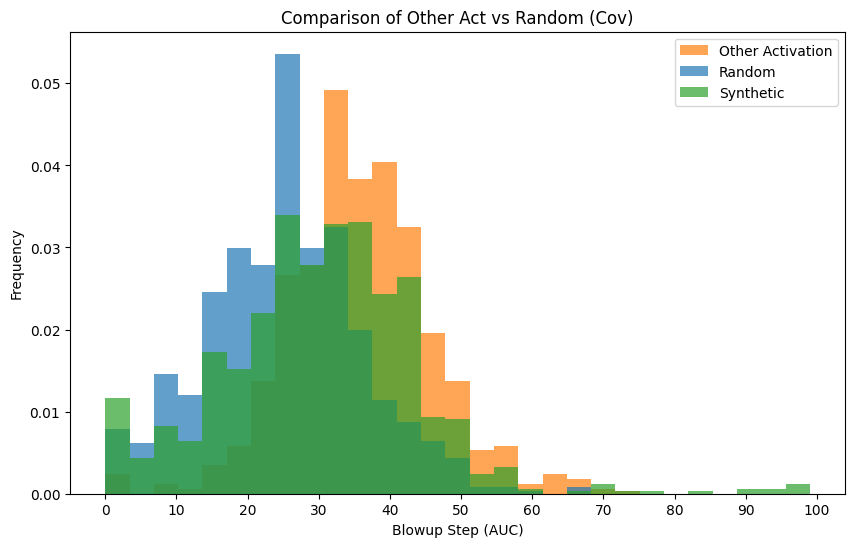

In [62]:
# Create the plot
plt.figure(figsize=(10, 6))

all_data = np.concatenate([ms_other, ms_random, ms_synth])
bins = np.linspace(min(all_data), max(all_data), 30)

# Plot both histograms
plt.hist(
    ms_other,
    bins=bins,
    alpha=0.7,
    label="Other Activation",
    density=True,
    color="tab:orange",
)
plt.hist(
    ms_random,
    bins=bins,
    alpha=0.7,
    label="Random",
    density=True,
    color="tab:blue",
)
plt.hist(
    ms_synth,
    bins=bins,
    alpha=0.7,
    label="Synthetic",
    density=True,
    color="tab:green",
)

plt.xticks(np.arange(0, 101, 10))

# Customize the plot
plt.xlabel("Blowup Step (AUC)")
plt.ylabel("Frequency")
plt.title("Comparison of Other Act vs Random (Cov)")
plt.legend()

# Show the plot
plt.show()

In [64]:
quantify_similarity(ms_other, ms_random, ms_synth)

Similarity score (ms_other vs ms_random): 0.5740
Similarity score (ms_other vs ms_synth): 0.7710
Similarity score (ms_synth vs ms_random): 0.7970
ms_synth is 1.34 times more similar to ms_other than ms_random is.
ms_synth appears to be between ms_other and ms_random in terms of similarity.


In [65]:
print(f"MS Other Act mean: {np.mean(ms_other)}, Std: {np.std(ms_other):.2f}")
print(f"MS Synthetic Act mean: {np.mean(ms_synth)}, Std: {np.std(ms_synth):.2f}")
print(f"MS Random Act mean: {np.mean(ms_random)}, Std: {np.std(ms_random):.2f}")

MS Other Act mean: 35.87, Std: 10.12
MS Synthetic Act mean: 30.175, Std: 14.03
MS Random Act mean: 25.237, Std: 10.95
